In [250]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# from allen_v1dd.client import OPhysClient
from allen_v1dd.stimulus_analysis import analysis_tools as at
from allen_v1dd.stimulus_analysis.analysis_tools import iter_plane_groups, get_roi_id

from allen_v1dd.stimulus_analysis.drifting_gratings import load_dg_xarray_from_h5
from allen_v1dd.stimulus_analysis.fit_utils import r2_score

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [251]:
at.set_stylesheet()
at.set_analysis_file("/Users/chase/Desktop/stimulus_analyses_v2.h5")
at.set_included_mice(409828)
at.set_included_columns([2, 3, 4, 5])

In [6]:
DG_TYPES = ["windowed", "full"]

def get_running_stationary_trial_mask(dg):
    abs_trial_run_speed = np.abs(dg["trial_running_speeds"])
    run_mask = abs_trial_run_speed > 1
    stationary_mask = abs_trial_run_speed <= 1
    return run_mask, stationary_mask

# Population average responses

In [219]:
df = []
AVERAGE_ALL_DIR = False

for group in iter_plane_groups(filter=dict(mouse=409828, column=1)):
    inclusion = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()]
    mouse = group.attrs["mouse"]
    column = group.attrs["column"]
    volume = group.attrs["volume"]
    plane = group.attrs["plane"]
    depth = group.attrs["plane_depth_microns"]

    with warnings.catch_warnings():
        warnings.filterwarnings(action="ignore", message="Mean of empty slice", category=RuntimeWarning)

        for dg_type in DG_TYPES:
            dg = group[f"drifting_gratings_{dg_type}"]
            frac_resp_trials = dg["frac_responsive_trials"][()]
            is_responsive = inclusion# & (frac_resp_trials >= 0.25)
            trial_responses = dg["trial_responses"][()]
            pref_cond_idx = dg["pref_cond_index"][()]
            running_mask, stationary_mask = get_running_stationary_trial_mask(dg)
            mean_blank_response = dg["blank_responses"][()].mean(axis=1)

            # for roi in np.where(is_responsive)[0]:
            for roi in np.where(inclusion)[0]:
                roi_trial_responses = trial_responses[roi]
                pref_dir_idx, pref_sf_idx = pref_cond_idx[roi]

                if AVERAGE_ALL_DIR:
                    mean_resp = np.nanmean(roi_trial_responses[:, pref_sf_idx, :])
                    mean_resp_running = np.nanmean(np.where(running_mask, trial_responses, np.nan)[:, pref_sf_idx, :])
                    mean_resp_stationary = np.nanmean(np.where(stationary_mask, trial_responses, np.nan)[:, pref_sf_idx, :])
                else:
                    mean_resp = np.nanmean(roi_trial_responses[pref_dir_idx, pref_sf_idx, :])
                    mean_resp_running = np.nanmean(np.where(running_mask, trial_responses, np.nan)[pref_dir_idx, pref_sf_idx, :])
                    mean_resp_stationary = np.nanmean(np.where(stationary_mask, trial_responses, np.nan)[pref_dir_idx, pref_sf_idx, :])

                df.append(dict(
                    roi = f"M{mouse}_{column}{volume}_{plane}_{roi}",
                    dg_type = dg_type,
                    frac_resp_trials = frac_resp_trials[roi],
                    is_responsive = is_responsive[roi],
                    mean_blank_resp = mean_blank_response[roi],
                    mean_resp = mean_resp,
                    mean_resp_running = mean_resp_running,
                    mean_resp_stationary = mean_resp_stationary,
                ))
    
df = pd.DataFrame(df)
df

,roi,dg_type,frac_resp_trials,is_responsive,mean_blank_resp,mean_resp,mean_resp_running,mean_resp_stationary
0,M409828_11_0_89,windowed,0.375000,True,0.000000,0.001066,0.000503,0.000153
1,M409828_11_0_89,full,0.500000,True,0.000219,0.001011,0.000298,0.000312
2,M409828_11_1_2,windowed,0.500000,True,0.000000,0.001273,0.001418,0.001596
3,M409828_11_1_4,windowed,0.428571,True,0.000087,0.000668,0.001542,0.000841
4,M409828_11_1_159,windowed,0.500000,True,0.000370,0.001843,0.000732,0.000298
...,...,...,...,...,...,...,...,...
14923,M409828_1f_0_67,full,0.200000,True,0.001526,0.003746,0.002531,0.002362
14924,M409828_1f_0_69,full,0.250000,True,0.003246,0.004276,0.000735,0.000779
14925,M409828_1f_0_70,full,0.625000,True,0.000000,0.016766,0.002000,0.001375
14926,M409828_1f_0_74,full,0.375000,True,0.000751,0.003375,0.000844,0.000723


In [111]:
df_w = df[df.dg_type == "windowed"]
df_f = df[df.dg_type == "full"]
df_merged = pd.merge(left=df_w, right=df_f, on="roi", how="inner", suffixes=["_windowed", "_full"])
df_merged = df_merged[df_merged.is_responsive_windowed] # Inclusion criteria
# df_merged = df_merged[df_merged.is_responsive_windowed | df_merged.is_responsive_full] # Inclusion criteria
df_merged = df_merged[[c for c in df_merged.columns if "dg_type" not in c]] # Remove unnecessary columns
df_merged.set_index("roi", inplace=True)
df_merged

,is_responsive_windowed,mean_blank_resp_windowed,mean_resp_windowed,mean_resp_running_windowed,mean_resp_stationary_windowed,is_responsive_full,mean_blank_resp_full,mean_resp_full,mean_resp_running_full,mean_resp_stationary_full
roi,,,,,,,,,,
M409828_11_0_89,True,0.000000,0.001066,0.000503,0.000153,True,0.000219,0.001011,0.000298,0.000312
M409828_11_1_2,True,0.000000,0.001273,0.001418,0.001596,True,0.000179,0.001315,0.000431,0.000546
M409828_11_1_4,True,0.000087,0.000668,0.001542,0.000841,False,0.000196,0.001176,0.001603,0.001786
M409828_11_1_159,True,0.000370,0.001843,0.000732,0.000298,True,0.000386,0.001336,0.000431,0.000546
M409828_11_2_0,True,0.000141,0.026140,0.008764,0.000000,True,0.000503,0.043148,0.021348,0.016349
...,...,...,...,...,...,...,...,...,...,...
M409828_1f_0_26,True,0.001078,0.002072,0.002564,0.000825,True,0.001614,0.004280,0.000000,0.000813
M409828_1f_0_29,True,0.000764,0.002783,0.001963,0.001239,True,0.002255,0.003227,0.002531,0.002362
M409828_1f_0_34,True,0.000397,0.001781,0.000850,0.001362,True,0.000511,0.001557,0.000844,0.000723


In [112]:
df_merged_norm = df_merged.divide(df_merged.mean_resp_stationary_windowed, axis=0)
df_merged_norm

,is_responsive_windowed,mean_blank_resp_windowed,mean_resp_windowed,mean_resp_running_windowed,mean_resp_stationary_windowed,is_responsive_full,mean_blank_resp_full,mean_resp_full,mean_resp_running_full,mean_resp_stationary_full
roi,,,,,,,,,,
M409828_11_0_89,6541.020443,0.000000,6.975096,3.287929,1.0,6541.020443,1.434034,6.609817,1.952279,2.040695
M409828_11_1_2,626.579692,0.000000,0.797745,0.888358,1.0,626.579692,0.112049,0.823655,0.269793,0.341862
M409828_11_1_4,1189.080660,0.103404,0.794218,1.834043,1.0,0.000000,0.233029,1.398951,1.905934,2.123903
M409828_11_1_159,3358.552485,1.242146,6.190981,2.458353,1.0,3358.552485,1.296785,4.485448,1.446128,1.832428
M409828_11_2_0,inf,inf,inf,inf,NaN,inf,inf,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...
M409828_1f_0_26,1211.994476,1.306094,2.511331,3.108120,1.0,1211.994476,1.955699,5.186932,0.000000,0.985812
M409828_1f_0_29,807.217443,0.617017,2.246171,1.584886,1.0,807.217443,1.820252,2.605203,2.043187,1.906946
M409828_1f_0_34,734.208769,0.291464,1.307491,0.623736,1.0,734.208769,0.375096,1.143314,0.619579,0.530758


(0.0, 10.0)

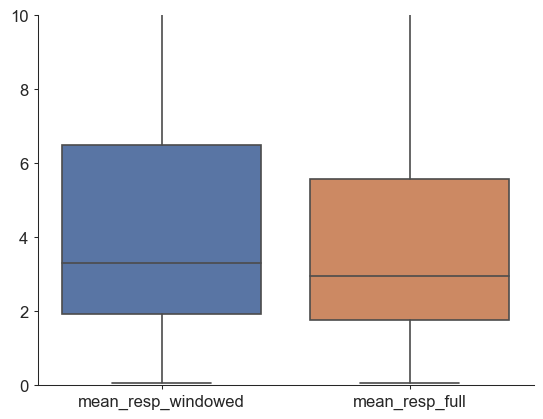

In [113]:
sns.boxplot(df_merged_norm[["mean_resp_windowed", "mean_resp_full"]])
plt.ylim(0, 10)

Text(0.5, 1.0, 'Mean response, normalized to mean_resp_stationary_windowed')

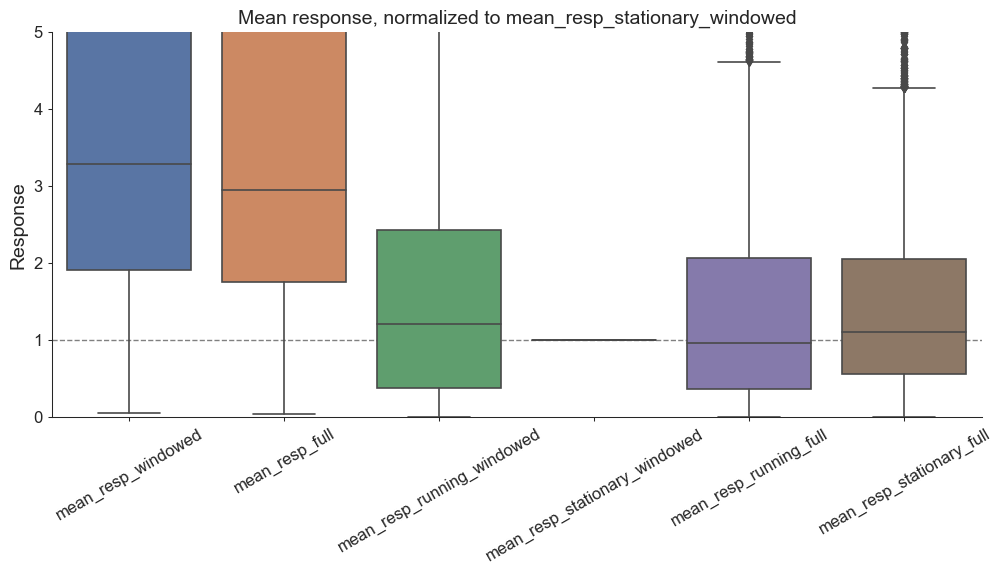

In [118]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(df_merged_norm[["mean_resp_windowed", "mean_resp_full", "mean_resp_running_windowed", "mean_resp_stationary_windowed", "mean_resp_running_full", "mean_resp_stationary_full"]], ax=ax)
plt.setp(ax.get_xticklabels(), rotation=30)
ax.set_ylim(0, 5)
ax.axhline(y=1, color="gray", linestyle="dashed", linewidth=1, zorder=0)
ax.set_ylabel("Response")
ax.set_title("Mean response, normalized to mean_resp_stationary_windowed")

Text(0.5, 1.0, 'Mean response, normalized to mean_resp_stationary_windowed')

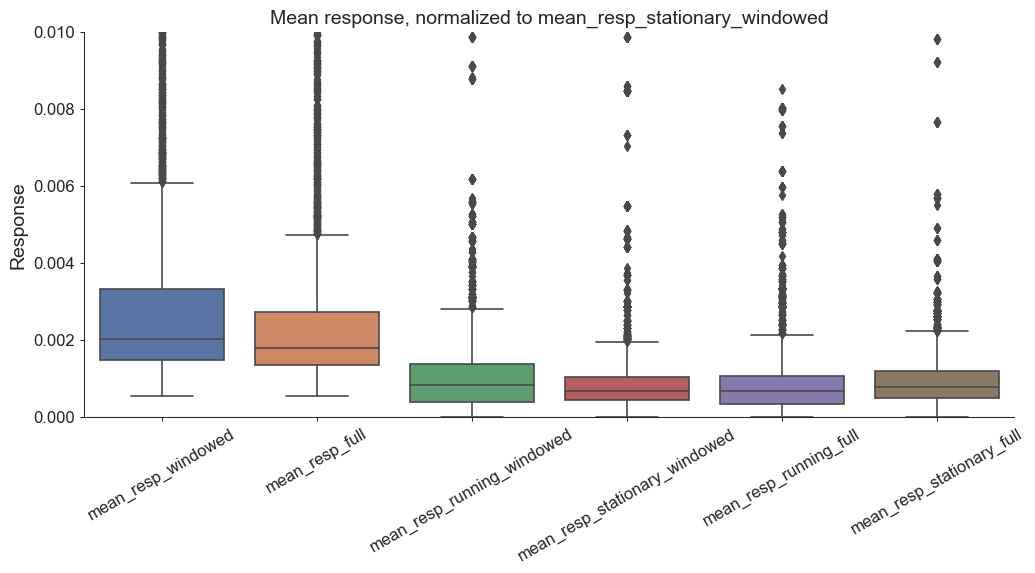

In [120]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(df_merged[["mean_response", "mean_resp_windowed", "mean_resp_full", "mean_resp_running_windowed", "mean_resp_stationary_windowed", "mean_resp_running_full", "mean_resp_stationary_full"]], ax=ax)
plt.setp(ax.get_xticklabels(), rotation=30)
ax.set_ylim(0, 0.01)
ax.set_ylabel("Response")
ax.set_title("Mean response, normalized to mean_resp_stationary_windowed")

In [167]:
a = np.full(5, np.nan)
a[2] = 1
b = np.array([np.nan, np.nan, 2, 3, np.nan])

a = np.where(np.isnan(a) | (b < a), b, a)
a

array([nan, nan,  1.,  3., nan])

In [220]:
rf_df = []

for group in iter_plane_groups(filter=dict()): # No filter - i.e., include all plane groups
    inclusion = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()]
    lsn = group["locally_sparse_noise"]
    overall_rf_dist = np.full(len(inclusion), np.inf, dtype=float)
    overall_rf_dist_argmax = np.full(len(inclusion), np.inf, dtype=float)

    for onoff in range(2):
        responsive = inclusion & lsn["is_responsive"][:, onoff]

        rf_dist = lsn["rf_centers"][:, onoff]
        rf_dist[~responsive] = np.nan
        rf_dist = np.linalg.norm(rf_dist, axis=1)
        overall_rf_dist = np.where(np.isnan(overall_rf_dist) | (rf_dist < overall_rf_dist), rf_dist, overall_rf_dist)
        
        rf_dist = lsn["rf_centers_argmax"][:, onoff]
        rf_dist[~responsive] = np.nan
        rf_dist = np.linalg.norm(rf_dist, axis=1)
        overall_rf_dist_argmax = np.where(np.isnan(overall_rf_dist_argmax) | (rf_dist < overall_rf_dist_argmax), rf_dist, overall_rf_dist_argmax)

    for roi in np.where(np.isfinite(overall_rf_dist))[0]:
        rf_df.append(dict(
            roi_id = get_roi_id(group, roi),
            column = group.attrs['column'],
            rf_dist = overall_rf_dist[roi],
            rf_dist_argmax = overall_rf_dist_argmax[roi]
        ))


    # np.sqrt(lsn_metrics.rf_on_alt_deg**2 + lsn_metrics.rf_on_azi_deg**2)

rf_df = pd.DataFrame(rf_df)
rf_df

# TODO make DF of RF locations and merge with other DF

,roi_id,column,rf_dist,rf_dist_argmax
0,M409828_11_0_89,1,8.419019,48.180252
1,M409828_11_1_4,1,0.413919,13.577545
2,M409828_11_2_5,1,3.359550,39.073135
3,M409828_11_2_8,1,1.814965,35.739038
4,M409828_11_2_24,1,5.932842,35.739038
...,...,...,...,...
35972,M438833_55_5_72,5,39.073135,64.737244
35973,M438833_55_5_80,5,10.165876,13.577545
35974,M438833_55_5_96,5,32.596674,54.456807
35975,M438833_55_5_116,5,5.932842,41.529896


In [215]:
(rf_df.rf_dist <= 10).sum()

14566

,is_responsive_windowed,mean_blank_resp_windowed,mean_resp_windowed,mean_resp_running_windowed,mean_resp_stationary_windowed,is_responsive_full,mean_blank_resp_full,mean_resp_full,mean_resp_running_full,mean_resp_stationary_full
roi,,,,,,,,,,
M409828_11_0_89,6541.020443,0.000000,6.975096,3.287929,1.0,6541.020443,1.434034,6.609817,1.952279,2.040695
M409828_11_1_4,1189.080660,0.103404,0.794218,1.834043,1.0,0.000000,0.233029,1.398951,1.905934,2.123903
M409828_11_2_5,2210.984434,0.997587,2.414756,0.543046,1.0,2210.984434,0.524495,2.304624,0.642033,0.547593
M409828_11_3_22,3098.814876,0.662126,25.171982,4.539373,1.0,3098.814876,1.611705,4.187652,2.753834,2.929785
M409828_11_3_43,inf,NaN,inf,inf,NaN,inf,NaN,inf,inf,inf
...,...,...,...,...,...,...,...,...,...,...
M409828_1d_0_182,597.174181,0.461600,2.474903,1.322166,1.0,0.000000,0.809664,1.250742,0.000000,1.230624
M409828_1d_0_187,1142.542013,0.695788,8.561104,2.458326,1.0,1142.542013,1.891790,13.431805,NaN,1.175664
M409828_1e_0_124,597.380152,0.590697,1.115382,0.748247,1.0,0.000000,0.000000,1.111786,0.528617,0.311444


Text(0.5, 1.0, 'Mean response, normalized to mean_resp_stationary_windowed')

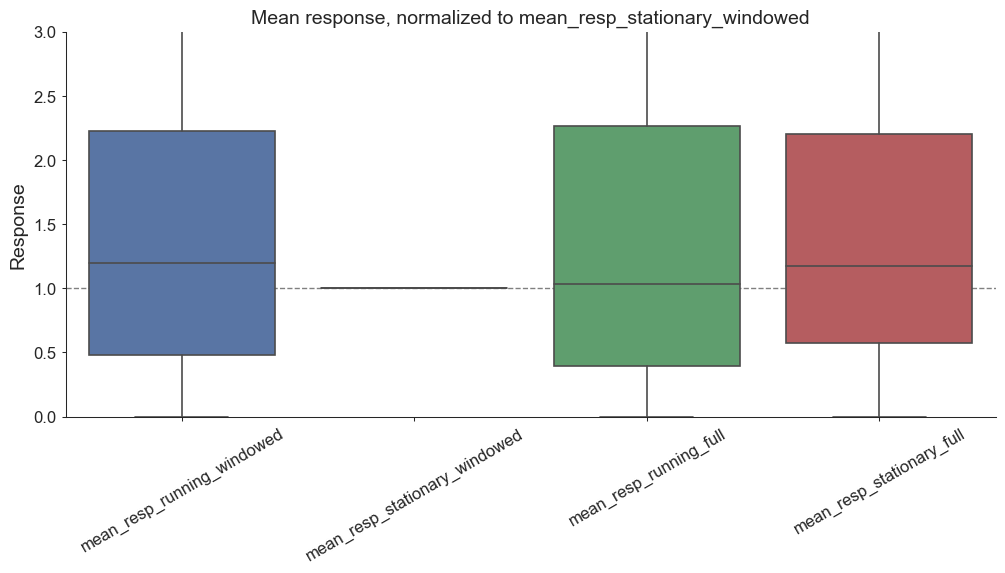

In [218]:
df = df_merged_norm[df_merged_norm.index.isin(rf_df.roi_id[rf_df.rf_dist <= 10])]

fig, ax = plt.subplots(figsize=(12, 5))
# sns.boxplot(df[["mean_resp_windowed", "mean_resp_full", "mean_resp_running_windowed", "mean_resp_stationary_windowed", "mean_resp_running_full", "mean_resp_stationary_full"]], ax=ax)
# ax.set_ylim(0, 5)
sns.boxplot(df[["mean_resp_running_windowed", "mean_resp_stationary_windowed", "mean_resp_running_full", "mean_resp_stationary_full"]], ax=ax)
ax.set_ylim(0, 3)
plt.setp(ax.get_xticklabels(), rotation=30)
ax.axhline(y=1, color="gray", linestyle="dashed", linewidth=1, zorder=0)
ax.set_ylabel("Response")
ax.set_title("Mean response, normalized to mean_resp_stationary_windowed")

# Look a pref dir distributions as a function of depth

In [227]:
dg_df = []

for group in iter_plane_groups():
    inclusion = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()]
    depth = group.attrs["plane_depth_microns"]

    for dg_type in DG_TYPES:
        dg = group[f"drifting_gratings_{dg_type}"]
        frac_resp_trials = dg["frac_responsive_trials"][()]
        is_responsive = inclusion & (frac_resp_trials >= 0.25)
        trial_responses = dg["trial_responses"][()]
        pref_cond = dg["pref_cond"][()]

        for roi in np.where(is_responsive)[0]:
            dg_df.append(dict(
                roi_id = get_roi_id(group, roi),
                dg_type = dg_type,
                frac_resp_trials = frac_resp_trials[roi],
                depth = depth,
                pref_dir = pref_cond[roi, 0],
                pref_sf = pref_cond[roi, 1]
            ))

dg_df = pd.DataFrame(dg_df)
dg_df["depth_trunc"] = (dg_df.depth / 100).astype(int) * 100
dg_df

,roi_id,dg_type,frac_resp_trials,depth,pref_dir,pref_sf
0,M409828_21_0_0,windowed,0.666667,50,60.0,0.04
1,M409828_21_0_1,windowed,0.500000,50,90.0,0.04
2,M409828_21_0_4,windowed,0.750000,50,240.0,0.04
3,M409828_21_0_149,windowed,0.625000,50,0.0,0.04
4,M409828_21_0_0,full,0.750000,50,60.0,0.04
...,...,...,...,...,...,...
33439,M409828_55_5_52,full,0.375000,514,30.0,0.04
33440,M409828_55_5_55,full,0.250000,514,150.0,0.04
33441,M409828_55_5_67,full,0.285714,514,240.0,0.04
33442,M409828_55_5_73,full,0.571429,514,120.0,0.04


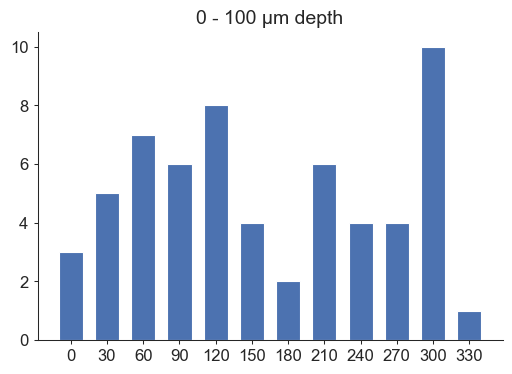

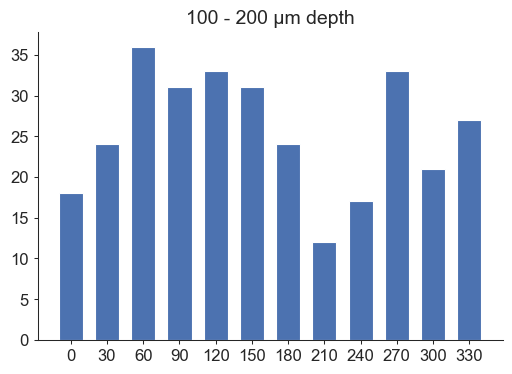

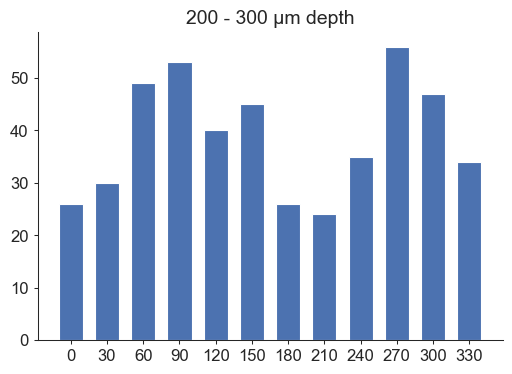

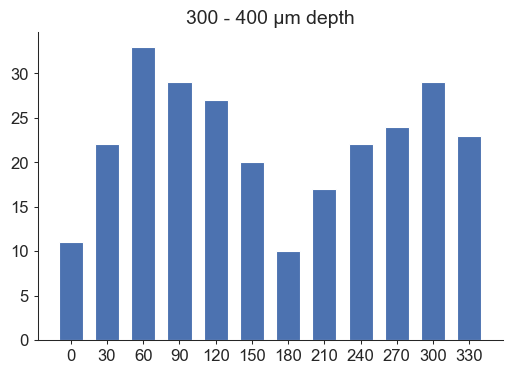

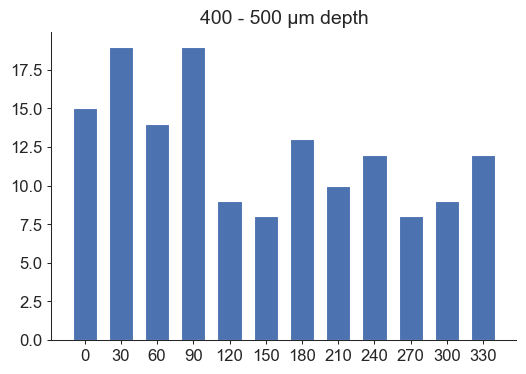

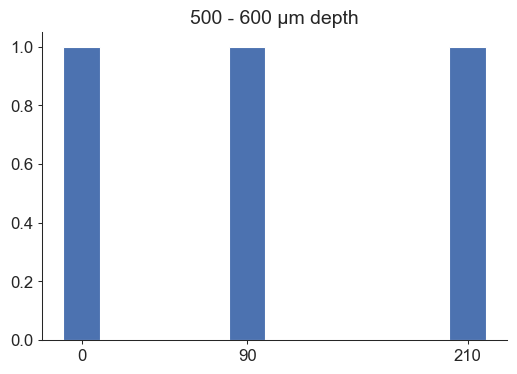

In [247]:
for d in dg_df.depth_trunc.unique():
    plt.figure(figsize=(6, 4))
    df = dg_df[(dg_df.depth_trunc == d) & (dg_df.dg_type == "windowed")]
    df = df[df.roi_id.isin(rf_df.roi_id[rf_df.rf_dist < 10])]
    dir_counts = df.pref_dir.astype(int).value_counts().sort_index()

    plt.bar(x=dir_counts.index, height=dir_counts.values, width=20)
    plt.xticks(dir_counts.index)
    plt.title(f"{d} - {d+100} µm depth")


(array([5011., 2901., 3713., 2799., 1741., 2197., 1886., 2466., 4470.,
        6260.]),
 array([  0.,  33.,  66.,  99., 132., 165., 198., 231., 264., 297., 330.]),
 <BarContainer object of 10 artists>)

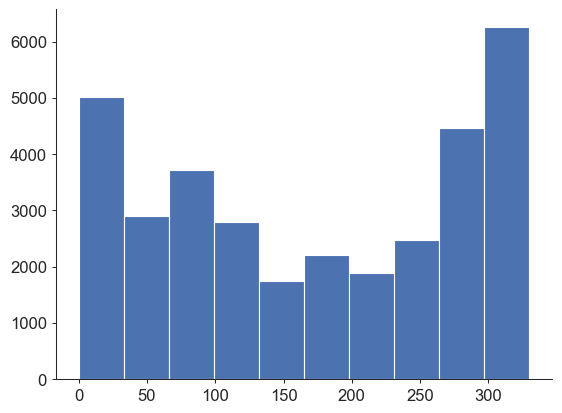

In [253]:
ssi_df = []

for group in iter_plane_groups():
    inclusion = group["is_roi_valid"][()] & ~group["is_ignored_duplicate"][()]
    depth = group.attrs["plane_depth_microns"]
    ssi = group["ssi"]

    for roi in np.where(inclusion)[0]:
        ssi_normal = ssi["ssi_avg_at_pref_sf"][roi]
        ssi_run = ssi["ssi_running_avg_at_pref_sf"][roi]
        ssi_stat = ssi["ssi_stationary_avg_at_pref_sf"][roi]

        ssi_df.append(dict(
            roi_id = get_roi_id(group, roi),
            depth = depth,
            ssi_normal = ssi_normal,
            ssi_run = ssi_run,
            ssi_stat = ssi_stat
        ))

ssi_df = pd.DataFrame(ssi_df)
ssi_df

,roi_id,depth,ssi_normal,ssi_run,ssi_stat
0,M409828_21_0_0,50,0.138997,0.338794,-0.222836
1,M409828_21_0_1,50,0.069426,0.154399,-0.082297
2,M409828_21_0_4,50,-0.051058,0.069911,-0.273103
3,M409828_21_0_149,50,-0.075151,0.054254,-0.298160
4,M409828_21_1_0,66,0.041724,0.018082,0.098423
...,...,...,...,...,...
22700,M409828_55_5_55,514,0.231198,NaN,0.228140
22701,M409828_55_5_67,514,0.123197,NaN,0.104663
22702,M409828_55_5_73,514,0.022186,NaN,0.014058
22703,M409828_55_5_74,514,0.164589,NaN,0.199769


<Axes: xlabel='ssi_stat', ylabel='depth'>

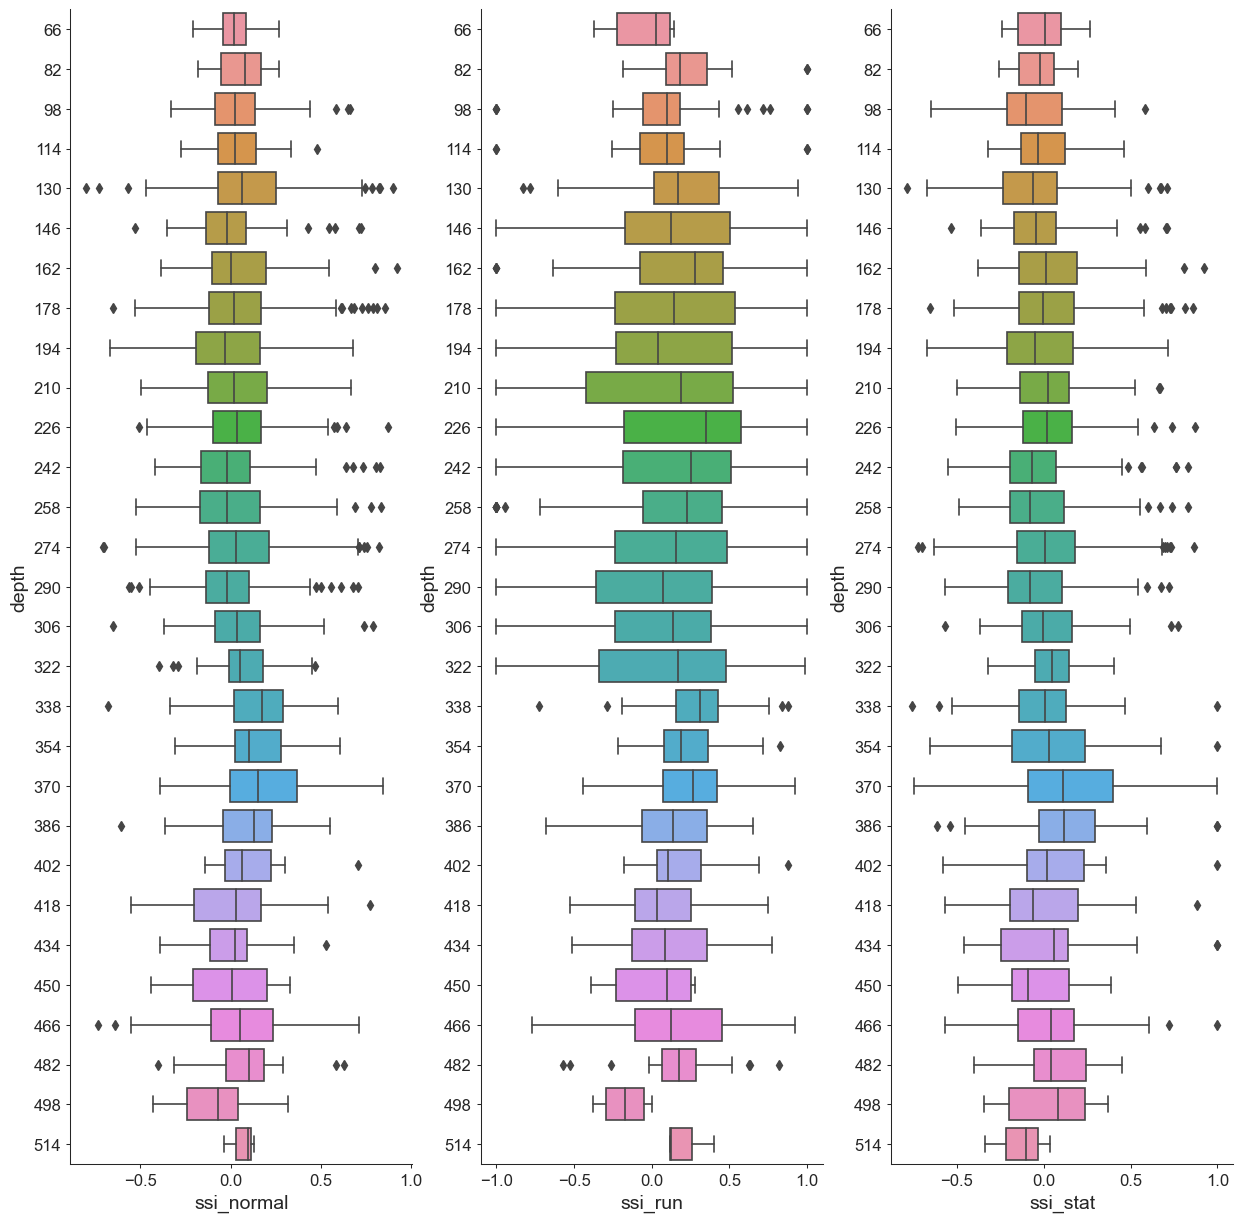

In [259]:
df = ssi_df.merge(rf_df, how="left", on="roi_id")
df = df[df.rf_dist <= 10]

fig, axs = plt.subplots(figsize=(15, 15), ncols=3)
sns.boxplot(data=df, x="ssi_normal", y="depth", orient="horizontal", ax=axs[0])
sns.boxplot(data=df, x="ssi_run", y="depth", orient="horizontal", ax=axs[1])
sns.boxplot(data=df, x="ssi_stat", y="depth", orient="horizontal", ax=axs[2])

In [267]:
df["ssi_run_index"] = df.apply(lambda row: row.ssi_run - row.ssi_stat, axis=1)
df

,roi_id,depth,ssi_normal,ssi_run,ssi_stat,column,rf_dist,rf_dist_argmax,ssi_run_index
14,M409828_21_1_24,66,-0.015106,0.114787,-0.227876,2.0,1.962902,32.596674,0.342663
15,M409828_21_1_25,66,-0.047553,0.026186,-0.238910,2.0,4.842804,21.969342,0.265096
27,M409828_21_2_5,82,0.092553,0.114760,0.057558,2.0,3.182073,47.481401,0.057203
37,M409828_21_2_15,82,0.157615,0.192961,0.109401,2.0,5.492335,12.947449,0.083560
61,M409828_21_2_40,82,-0.073900,0.022884,-0.242137,2.0,2.907464,30.497629,0.265021
...,...,...,...,...,...,...,...,...,...
22548,M409828_55_2_269,466,-0.012802,NaN,0.024642,5.0,9.212101,13.577545,NaN
22580,M409828_55_3_94,482,0.133672,NaN,0.188599,5.0,4.317857,53.395580,NaN
22619,M409828_55_3_234,482,0.236690,NaN,0.319586,5.0,8.137500,43.863690,NaN
22625,M409828_55_4_1,498,0.318120,NaN,0.289245,5.0,4.393868,12.947449,NaN


(array([ 23.,  41.,  58.,  76.,  83., 119., 140., 135., 142., 128.,  96.]),
 array([-0.55, -0.45, -0.35, -0.25, -0.15, -0.05,  0.05,  0.15,  0.25,
         0.35,  0.45,  0.55]),
 <BarContainer object of 11 artists>)

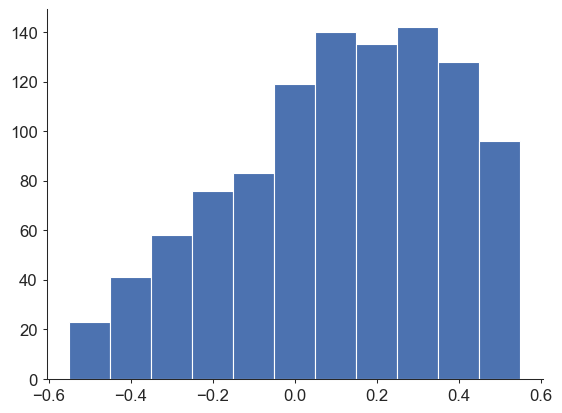

In [268]:
plt.hist(df.ssi_run_index, bins=np.arange(-0.55, 0.6, 0.1))